In [1]:
from adjustText import adjust_text
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.stats import fisher_exact
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import yaml

In [2]:
PLOT_DIR = "../../results/plots/score_consequence/"
os.makedirs(PLOT_DIR, exist_ok=True)

with open('../../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [3]:
consequence_renaming = {
    "5-prime-UTR": "5' UTR",
    "3-prime-UTR": "3' UTR",
    "non-coding-transcript-exon": "ncRNA",
}

In [4]:
def calculate_enrichment(df):
    df["proportion"] = df["count"] / df["count"].sum(axis=0)
    df["other_proportion"] = df["other_count"] / df["other_count"].sum(axis=0)
    df["global_proportion"] = df["global_count"] / df["global_count"].sum(axis=0)
    df.consequence = df.consequence.str.replace("_variant", "").str.replace("_", "-")
    df.consequence = df.consequence.map(lambda x: consequence_renaming.get(x, x))

    # Calculate total counts for sample and global datasets
    total_count = df['count'].sum()
    total_other_count = df['other_count'].sum()
    
    # A list to store the results
    results = []
    
    # Iterate over each row to perform the test
    for index, row in df.iterrows():
        # Create the 2x2 contingency table
        table = [
            [row['count'], total_count - row['count']],
            [row['other_count'], total_other_count - row['other_count']],
        ]
        
        # Perform a two-sided Fisher's Exact Test
        # This returns the Odds Ratio and the P-value
        odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
        
        results.append({
            'consequence': row['consequence'],
            'odds ratio': odds_ratio,
            'p_value': p_value
        })
    
    # Create a new dataframe from the results
    results_df = pd.DataFrame(results)
    
    # Merge the results back into the original dataframe if desired
    df = pd.merge(df, results_df, on='consequence')
    
    # Correct for multiple testing using Benjamini-Hochberg (FDR)
    rejected, q_values = fdrcorrection(df['p_value'])
    
    # Add the Odds Ratio and q-value to your dataframe
    # The Odds Ratio is now your new enrichment score
    #df2['odds ratio'] = results_df['odds_ratio'] 
    df['q_value'] = q_values
    df["significant"] = rejected
    
    # Display the final results, sorted by significance
    # A very high or very low odds ratio with a small q-value is interesting.
    return df


def plot_enrichment(df, figsize=8, save_path=None):
    fig, ax = plt.subplots(figsize=(figsize, figsize))    
    # Create the scatter plot
    # x-axis is 'proportion', y-axis is 'odds ratio'
    scatter = ax.scatter(df['proportion'], df['odds ratio'], alpha=0.7, edgecolors='w', s=100)
    plt.axhline(y=1, color='gray', linestyle='--')
    
    # Set the y-axis to a logarithmic scale for better visualization
    # This is useful when data spans several orders of magnitude, like your odds ratios.
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Set titles and labels for clarity
    ax.set_xlabel('Proportion')
    ax.set_ylabel('Odds ratio')
    
    # Create a list of text annotations
    texts = []
    for i, txt in enumerate(df['consequence']):
        texts.append(ax.text(df['proportion'][i], df['odds ratio'][i], txt))
    
    # Use adjust_text to prevent labels from overlapping
    # This function will automatically move the text labels to be more readable.
    # The arrowprops add arrows pointing from the text to the point.
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    sns.despine();
    plt.tight_layout()
    if save_path is not None:
        for ext in [".svg", ".pdf"]:
            plt.savefig(PLOT_DIR + save_path + ext, bbox_inches="tight")


def custom_format(n):
  """
  Formats a number to two decimal places,
  but uses scientific notation if its absolute value is less than 0.01.
  """
  if abs(n) < 0.01:
    # Use {:.0e} for scientific notation like '1e-7'
    return f"{n:.0e}"
  else:
    # Use {:.2f} for two fixed decimal places
    return f"{n:.2f}"


def enrich2latex(df):
    df2 = df.copy()
    df2.consequence = r"\verb|" + df2.consequence + r"|"
    df2['odds ratio'] = df2.apply(
        lambda row: f"\\textbf{{{row['odds ratio']:.2f}}}" if row['significant'] else f"{row['odds ratio']:.2f}",
        axis=1
    )
    df2.proportion = df2.proportion.apply(custom_format)
    df2 = df2[[
        "consequence",
        "count",
        "proportion",
        "odds ratio",
    ]]
    print(df2.to_latex(
        index=False, escape=False,
    ))


def calculate_enrichment_two_models(df: pd.DataFrame, model1: str, model2: str) -> pd.DataFrame:
    """
    Calculates the enrichment odds ratio and p-value for each consequence
    between two models using Fisher's exact test.

    Args:
        df: DataFrame with columns 'consequence', 'count', and 'model'.
        model1: The name of the first model (e.g., 'P').
        model2: The name of the second model (e.g., 'V').

    Returns:
        A DataFrame with 'consequence', 'odds_ratio', and 'p_value'.
    """
    # --- 1. Data Preparation ---
    # Filter the DataFrame to only include the two models of interest.
    df_models = df[df['model'].isin([model1, model2])].copy()

    # Pivot the table to make consequences as rows and models as columns.
    # This makes it easier to access counts for each model.
    contingency_table = df_models.pivot_table(
        index='consequence', 
        columns='model', 
        values='count', 
        fill_value=0
    )

    # Calculate the total counts for each model.
    total_model1 = contingency_table[model1].sum()
    total_model2 = contingency_table[model2].sum()

    # --- 2. Perform Enrichment Analysis for Each Consequence ---
    results = []
    # Iterate over each consequence present in the filtered data.
    for consequence, row in contingency_table.iterrows():
        # Counts for the specific consequence in each model.
        count_model1_consequence = row[model1]
        count_model2_consequence = row[model2]

        # Counts for all *other* consequences in each model.
        count_model1_other = total_model1 - count_model1_consequence
        count_model2_other = total_model2 - count_model2_consequence

        # --- 3. Construct the 2x2 Contingency Table ---
        # This table is the input for Fisher's exact test.
        #         | model1 | model2
        #  -------|--------|--------
        #  This   |   a    |   b
        #  Other  |   c    |   d
        table = [
            [count_model1_consequence, count_model2_consequence],
            [count_model1_other, count_model2_other]
        ]

        # --- 4. Perform Fisher's Exact Test ---
        # This test determines if there's a significant association
        # between the consequence and the model.
        try:
            odds_ratio, p_value = fisher_exact(table)
            results.append({
                'consequence': consequence,
                'odds_ratio': odds_ratio,
                'p_value': p_value
            })
        except ValueError as e:
            # This can happen if a row or column in the 2x2 table sums to zero.
            print(f"Could not calculate for '{consequence}': {e}")
            results.append({
                'consequence': consequence,
                'odds_ratio': float('nan'),
                'p_value': float('nan')
            })


    # --- 5. Return Results ---
    # Convert the list of dictionaries to a DataFrame for easy viewing.
    results_df = pd.DataFrame(results)

    if not results_df.empty:
        # Calculate q-values using Benjamini/Hochberg FDR method
        reject, q_values = fdrcorrection(results_df['p_value'], alpha=0.05)
        results_df['q_value'] = q_values
    
    # Sort by p-value to see the most significant results first.
    results_df = results_df.sort_values(by='q_value').reset_index(drop=True)
    
    return results_df


def enrich_two_models_to_latex(df):
    df2 = df.copy()
    df2.consequence = r"\verb|" + df2.consequence + r"|"
    for col in ["p_value", "q_value"]:
        df2[col] = [f"{x:.0e}" for x in df2[col]]
    print(df2.to_latex(
        index=False, escape=False, float_format="%.2f",
    ))

In [5]:
#annot_mode = "annot"
#annot_mode = "annot_with_cre_v1"
annot_mode = "annot_with_cre_v2"

In [6]:
global_count = pd.read_parquet(f"../../results/global_score_consequence/{annot_mode}.parquet").rename(columns=dict(count="global_count"))
global_count

,consequence,global_count,category
0,total,9997231,all
1,intron_variant,2019487,all
2,dELS-flank,1961210,all
3,intergenic_variant,1735479,all
4,dELS,1301715,all
...,...,...,...
110,start_lost,71,low-frequency
111,stop_lost,57,low-frequency
112,mature_miRNA_variant,55,low-frequency
113,stop_retained_variant,15,low-frequency


In [8]:
approach = "quantile"
q = 0.001

models = {
    "P": config["gpn_star_p"],
    "M": config["gpn_star_m"],
    "V": config["gpn_star_v"],
}

df = pd.concat(
    pd.read_parquet(f"../../results/score_consequence/{annot_mode}/{approach}/{model}/{q}.parquet").assign(model=model_name)
    for model_name, model in models.items()
)
df = df.merge(global_count, on=["consequence", "category"], how="left")
df["other_count"] = df["global_count"] - df["count"]
df

,consequence,count,category,model,global_count,other_count
0,total,16108,all,P,9997231,9981123
1,missense_variant,6494,all,P,41219,34725
2,dELS,3734,all,P,1301715,1297981
3,dELS-flank,1092,all,P,1961210,1960118
4,3_prime_UTR_variant,798,all,P,121697,120899
...,...,...,...,...,...,...
322,downstream_gene_variant,5,low-frequency,V,13232,13227
323,upstream_gene_variant,5,low-frequency,V,8542,8537
324,stop_lost,2,low-frequency,V,57,55
325,stop_retained_variant,1,low-frequency,V,15,14


# Main analysis

In [9]:
df2 = df.query('model == "P" and consequence != "total"')
df2

,consequence,count,category,model,global_count,other_count
1,missense_variant,6494,all,P,41219,34725
2,dELS,3734,all,P,1301715,1297981
3,dELS-flank,1092,all,P,1961210,1960118
4,3_prime_UTR_variant,798,all,P,121697,120899
5,non_coding_transcript_exon_variant,654,all,P,235231,234577
...,...,...,...,...,...,...
102,PLS-flank,6,low-frequency,P,3999,3993
103,stop_lost,4,low-frequency,P,57,53
104,mature_miRNA_variant,4,low-frequency,P,55,51
105,upstream_gene_variant,2,low-frequency,P,8542,8540


In [10]:
enrich_all = calculate_enrichment(df2.query("category == 'all'"))
enrich_all

/tmp/ipykernel_550241/3852203328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["proportion"] = df["count"] / df["count"].sum(axis=0)
/tmp/ipykernel_550241/3852203328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other_proportion"] = df["other_count"] / df["other_count"].sum(axis=0)
/tmp/ipykernel_550241/3852203328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,consequence,count,category,model,global_count,other_count,proportion,other_proportion,global_proportion,odds ratio,p_value,q_value,significant
0,missense,6494,all,P,41219,34725,0.403154,0.003482,0.004127,193.303837,0.000000e+00,0.000000e+00,True
1,dELS,3734,all,P,1301715,1297981,0.231810,0.130160,0.130324,2.016622,4.819276e-270,3.373493e-269,True
2,dELS-flank,1092,all,P,1961210,1960118,0.067792,0.196559,0.196351,0.297255,0.000000e+00,0.000000e+00,True
3,3' UTR,798,all,P,121697,120899,0.049541,0.012124,0.012184,4.247145,6.775225e-233,2.964161e-232,True
4,ncRNA,654,all,P,235231,234577,0.040601,0.023523,0.023551,1.756721,1.467554e-38,2.568219e-38,True
5,pELS,545,all,P,170904,170359,0.033834,0.017083,0.017110,2.014857,1.935448e-47,3.763372e-47,True
6,5' UTR,423,all,P,28582,28159,0.026260,0.002824,0.002862,9.523576,6.132449e-249,3.066225e-248,True
7,CA,322,all,P,241647,241325,0.019990,0.024200,0.024193,0.822492,3.952734e-04,4.323303e-04,True
8,PLS,255,all,P,24082,23827,0.015831,0.002389,0.002411,6.715988,7.624898e-118,2.223929e-117,True
9,intron,235,all,P,2019487,2019252,0.014589,0.202489,0.202186,0.058310,0.000000e+00,0.000000e+00,True


In [11]:
enrich_common = calculate_enrichment(df2.query("category == 'common'"))
enrich_common

/tmp/ipykernel_550241/3852203328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["proportion"] = df["count"] / df["count"].sum(axis=0)
/tmp/ipykernel_550241/3852203328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["other_proportion"] = df["other_count"] / df["other_count"].sum(axis=0)
/tmp/ipykernel_550241/3852203328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,consequence,count,category,model,global_count,other_count,proportion,other_proportion,global_proportion,odds ratio,p_value,q_value,significant
0,missense,1983,common,P,19310,17327,0.332662,0.002919,0.003250,170.270261,0.000000e+00,0.000000e+00,True
1,dELS,1564,common,P,770125,768561,0.262372,0.129481,0.129614,2.391411,1.752174e-165,1.489348e-164,True
2,dELS-flank,468,common,P,1170017,1169549,0.078510,0.197036,0.196917,0.347207,2.655677e-143,1.805861e-142,True
3,ncRNA,287,common,P,137567,137280,0.048146,0.023128,0.023153,2.136471,2.362412e-29,5.737287e-29,True
4,3' UTR,280,common,P,68705,68425,0.046972,0.011528,0.011563,4.226266,8.220876e-83,3.493872e-82,True
5,pELS,209,common,P,99143,98934,0.035061,0.016668,0.016686,2.143661,4.268668e-22,8.063039e-22,True
6,5' UTR,151,common,P,15800,15649,0.025331,0.002636,0.002659,9.831993,3.303386e-92,1.871919e-91,True
7,CA,135,common,P,145633,145498,0.022647,0.024512,0.024510,0.922151,3.787017e-01,4.023706e-01,False
8,intron,99,common,P,1200166,1200067,0.016608,0.202177,0.201991,0.066644,0.000000e+00,0.000000e+00,True
9,PLS,96,common,P,13588,13492,0.016105,0.002273,0.002287,7.184763,5.163401e-48,1.950618e-47,True


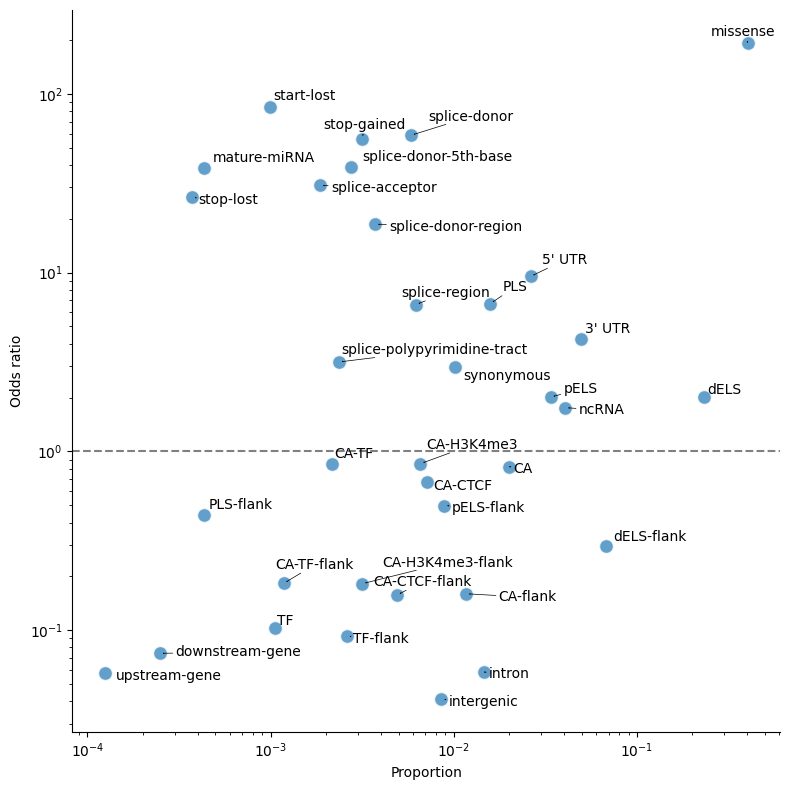

In [12]:
plot_enrichment(
    enrich_all,
    save_path="all",
)

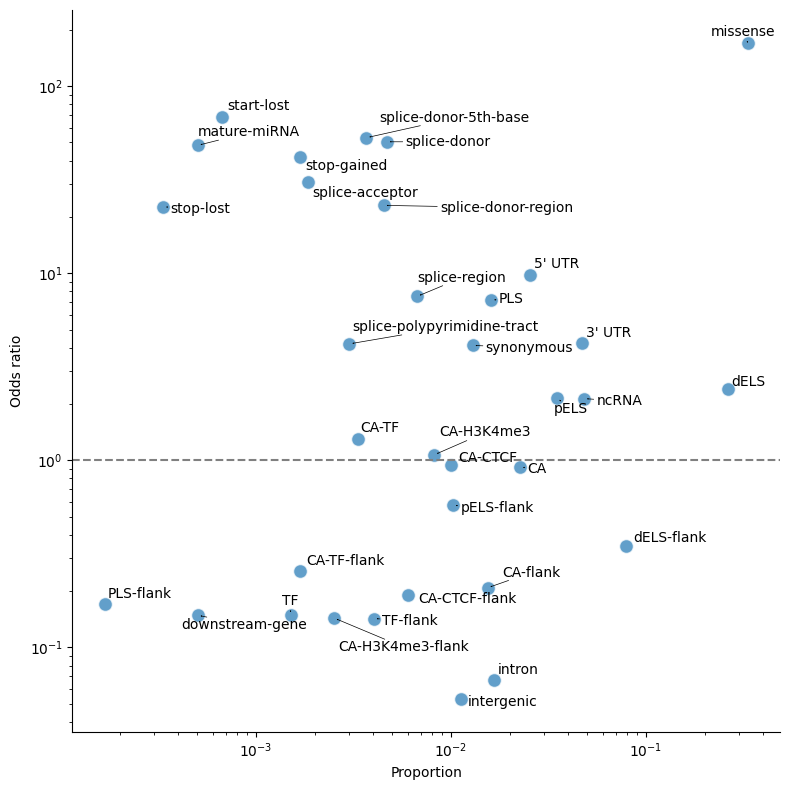

In [13]:
plot_enrichment(
    enrich_common,
    save_path="common",
)

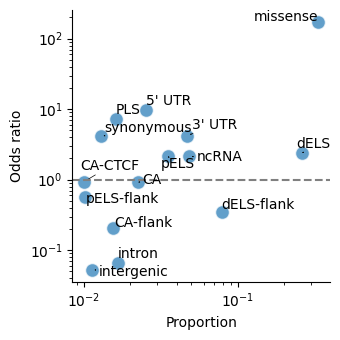

In [14]:
plot_enrichment(
    enrich_common[enrich_common.proportion > 1e-2],
    figsize=3.5,
    save_path="common_1pct",
)

In [15]:
enrich2latex(enrich_all)

\begin{tabular}{lrll}
\toprule
consequence & count & proportion & odds ratio \\
\midrule
\verb|missense| & 6494 & 0.40 & \textbf{193.30} \\
\verb|dELS| & 3734 & 0.23 & \textbf{2.02} \\
\verb|dELS-flank| & 1092 & 0.07 & \textbf{0.30} \\
\verb|3' UTR| & 798 & 0.05 & \textbf{4.25} \\
\verb|ncRNA| & 654 & 0.04 & \textbf{1.76} \\
\verb|pELS| & 545 & 0.03 & \textbf{2.01} \\
\verb|5' UTR| & 423 & 0.03 & \textbf{9.52} \\
\verb|CA| & 322 & 0.02 & \textbf{0.82} \\
\verb|PLS| & 255 & 0.02 & \textbf{6.72} \\
\verb|intron| & 235 & 0.01 & \textbf{0.06} \\
\verb|CA-flank| & 188 & 0.01 & \textbf{0.16} \\
\verb|synonymous| & 164 & 0.01 & \textbf{2.97} \\
\verb|pELS-flank| & 143 & 9e-03 & \textbf{0.50} \\
\verb|intergenic| & 138 & 9e-03 & \textbf{0.04} \\
\verb|CA-CTCF| & 115 & 7e-03 & \textbf{0.67} \\
\verb|CA-H3K4me3| & 106 & 7e-03 & 0.85 \\
\verb|splice-region| & 100 & 6e-03 & \textbf{6.63} \\
\verb|splice-donor| & 94 & 6e-03 & \textbf{58.71} \\
\verb|CA-CTCF-flank| & 79 & 5e-03 & \textbf{0.16} \\
\v

In [16]:
enrich2latex(enrich_common)

\begin{tabular}{lrll}
\toprule
consequence & count & proportion & odds ratio \\
\midrule
\verb|missense| & 1983 & 0.33 & \textbf{170.27} \\
\verb|dELS| & 1564 & 0.26 & \textbf{2.39} \\
\verb|dELS-flank| & 468 & 0.08 & \textbf{0.35} \\
\verb|ncRNA| & 287 & 0.05 & \textbf{2.14} \\
\verb|3' UTR| & 280 & 0.05 & \textbf{4.23} \\
\verb|pELS| & 209 & 0.04 & \textbf{2.14} \\
\verb|5' UTR| & 151 & 0.03 & \textbf{9.83} \\
\verb|CA| & 135 & 0.02 & 0.92 \\
\verb|intron| & 99 & 0.02 & \textbf{0.07} \\
\verb|PLS| & 96 & 0.02 & \textbf{7.18} \\
\verb|CA-flank| & 92 & 0.02 & \textbf{0.21} \\
\verb|synonymous| & 77 & 0.01 & \textbf{4.11} \\
\verb|intergenic| & 67 & 0.01 & \textbf{0.05} \\
\verb|pELS-flank| & 61 & 0.01 & \textbf{0.57} \\
\verb|CA-CTCF| & 60 & 0.01 & 0.94 \\
\verb|CA-H3K4me3| & 49 & 8e-03 & 1.07 \\
\verb|splice-region| & 40 & 7e-03 & \textbf{7.52} \\
\verb|CA-CTCF-flank| & 36 & 6e-03 & \textbf{0.19} \\
\verb|splice-donor| & 28 & 5e-03 & \textbf{50.38} \\
\verb|splice-donor-region| & 27 &

# Comparing models

In [17]:
df3 = df.query('consequence != "total"')
df3.consequence = df3.consequence.str.replace("_variant", "").str.replace("_", "-")
df3.consequence = df3.consequence.map(lambda x: consequence_renaming.get(x, x))
df3

/tmp/ipykernel_550241/2179783294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.consequence = df3.consequence.str.replace("_variant", "").str.replace("_", "-")
/tmp/ipykernel_550241/2179783294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.consequence = df3.consequence.map(lambda x: consequence_renaming.get(x, x))


,consequence,count,category,model,global_count,other_count
1,missense,6494,all,P,41219,34725
2,dELS,3734,all,P,1301715,1297981
3,dELS-flank,1092,all,P,1961210,1960118
4,3' UTR,798,all,P,121697,120899
5,ncRNA,654,all,P,235231,234577
...,...,...,...,...,...,...
322,downstream-gene,5,low-frequency,V,13232,13227
323,upstream-gene,5,low-frequency,V,8542,8537
324,stop-lost,2,low-frequency,V,57,55
325,stop-retained,1,low-frequency,V,15,14


In [18]:
calculate_enrichment_two_models(df3.query('category == "all"'), 'P', 'V').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
2,synonymous,3.222667,9.581134e-15,1.149736e-13
5,5' UTR,1.558302,1.878392e-08,1.127035e-07
17,splice-region,1.451452,1.944681e-02,3.889362e-02
0,missense,1.335150,4.731068e-35,1.703185e-33
13,PLS,1.287754,8.624142e-03,2.217636e-02
12,3' UTR,1.155010,7.400825e-03,2.049459e-02
11,dELS,0.926418,3.949042e-03,1.184712e-02
14,CA-CTCF,0.726208,1.142611e-02,2.742266e-02
15,CA-H3K4me3,0.722082,1.241839e-02,2.794137e-02
1,dELS-flank,0.695979,2.828527e-18,5.091348e-17


In [19]:
calculate_enrichment_two_models(df3.query('category == "all"'), 'P', 'M').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
0,missense,1.096892,0.000046,0.001673


In [20]:
calculate_enrichment_two_models(df3.query('category == "all"'), 'M', 'V').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
2,synonymous,2.565415,2.853540e-09,3.424248e-08
6,5' UTR,1.362202,1.263314e-04,6.497042e-04
10,PLS,1.281794,1.025061e-02,3.354745e-02
0,missense,1.217212,4.571408e-17,1.645707e-15
7,3' UTR,1.206609,4.165652e-04,1.666261e-03
8,intron,0.750984,4.085254e-04,1.666261e-03
1,dELS-flank,0.749316,1.366609e-12,2.459895e-11
5,CA-flank,0.714462,1.254815e-04,6.497042e-04
9,CA-H3K4me3,0.704859,7.068949e-03,2.544822e-02
3,CA,0.682286,1.690963e-07,1.521866e-06


In [21]:
calculate_enrichment_two_models(df3.query('category == "common"'), 'P', 'V').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
2,synonymous,3.887296,4.005002e-09,4.672502e-08
5,5' UTR,1.886658,4.078437e-06,2.379088e-05
9,PLS,1.757656,9.892589e-04,3.462406e-03
0,missense,1.521569,5.101503e-25,1.785526e-23
10,3' UTR,1.356456,1.206584e-03,3.839130e-03
1,dELS-flank,0.617253,7.016098e-15,1.227817e-13
7,CA,0.616311,1.349379e-05,5.903531e-05
6,CA-flank,0.557589,8.280767e-06,4.140384e-05
11,CA-CTCF-flank,0.551135,4.894260e-03,1.427493e-02
3,intron,0.542400,1.068775e-06,9.351779e-06


In [22]:
calculate_enrichment_two_models(df3.query('category == "common"'), 'P', 'M').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
0,missense,1.144134,0.000668,0.023374


In [23]:
calculate_enrichment_two_models(df3.query('category == "common"'), 'M', 'V').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)

,consequence,odds_ratio,p_value,q_value
2,synonymous,2.614080,1.989203e-04,2.320737e-03
7,5' UTR,1.504059,5.519800e-03,2.414912e-02
0,missense,1.329887,4.649735e-12,1.627407e-10
6,3' UTR,1.305713,5.089077e-03,2.414912e-02
1,dELS-flank,0.736398,3.264921e-07,5.713611e-06
8,CA-flank,0.712141,6.402850e-03,2.489997e-02
5,intron,0.693522,2.096493e-03,1.222954e-02
3,CA,0.686557,5.419115e-04,4.741726e-03
4,intergenic,0.621532,7.729401e-04,5.410581e-03


In [24]:
x = calculate_enrichment_two_models(df3.query('category == "common"'), 'P', 'M').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)
enrich_two_models_to_latex(x)

\begin{tabular}{lrll}
\toprule
consequence & odds_ratio & p_value & q_value \\
\midrule
\verb|missense| & 1.14 & 7e-04 & 2e-02 \\
\bottomrule
\end{tabular}



In [25]:
x = calculate_enrichment_two_models(df3.query('category == "common"'), 'P', 'V').query('q_value < 0.05').sort_values('odds_ratio', ascending=False)
enrich_two_models_to_latex(x)

\begin{tabular}{lrll}
\toprule
consequence & odds_ratio & p_value & q_value \\
\midrule
\verb|synonymous| & 3.89 & 4e-09 & 5e-08 \\
\verb|5' UTR| & 1.89 & 4e-06 & 2e-05 \\
\verb|PLS| & 1.76 & 1e-03 & 3e-03 \\
\verb|missense| & 1.52 & 5e-25 & 2e-23 \\
\verb|3' UTR| & 1.36 & 1e-03 & 4e-03 \\
\verb|dELS-flank| & 0.62 & 7e-15 & 1e-13 \\
\verb|CA| & 0.62 & 1e-05 & 6e-05 \\
\verb|CA-flank| & 0.56 & 8e-06 & 4e-05 \\
\verb|CA-CTCF-flank| & 0.55 & 5e-03 & 1e-02 \\
\verb|intron| & 0.54 & 1e-06 & 9e-06 \\
\verb|intergenic| & 0.49 & 2e-06 & 2e-05 \\
\verb|CA-H3K4me3-flank| & 0.34 & 2e-04 & 8e-04 \\
\bottomrule
\end{tabular}

